In [1]:
cd MF

/home/shse/Documents/stage_cnrs/mean-field-twoNW/Najwa/MF


In [2]:
import numpy as np
import sys
#sys.path.append('mean_field_adapt')
#from transfer_functions.tf_simulation import single_experiment_2,single_experiment
from transfer_functions.load_config import load_transfer_functions,load_transfer_functions_with_ALL_params
from scipy.integrate import odeint
from single_cell_models.cell_library import get_neuron_params
from synapses_and_connectivity.syn_and_connec_library import get_connectivity_and_synapses_matrix
from transfer_functions.tf_simulation import reformat_syn_parameters
import matplotlib.pylab as plt
from transfer_functions.data import *
from graphs import *


from scipy.optimize import fsolve
from scipy.optimize import minimize
import math

In [3]:
from MF_functions_clean import *

## First, build the MF architecture and set the right parameters


In [4]:
h=0.0001
T=0.005
Ntot=10000

number_of_populations=4 # variate this paramater, first are excitators and second inihibitors 
number_of_adaptive=2

p_con=np.ones((4,4))*(0.05) #np.ones((4,4))*(0.05) ou number_of_pop*0.05
#p_con[2][2]=0.6 #inh tres connecté 
#p_con[1][2]=p_con[2][1]=0 ## the two FS populations are not connected !
p_pois=np.ones(2)*0.05

''' Now params becomes a dictionary'''

#numb_par=28
params={}

params['diff']=[0,0,0,0] # by default nothing changes from neuron model
params['tstep']=5e-4 
params['numb_var']=number_of_populations**2+number_of_populations+number_of_adaptive#14 # total numb of var
# remove number_of_populations**2 for first order 
params['tauw']=[5e-1,5e-1,1e-3,1e-3] # tau_w
params['a']=[0,0,0,0] # a 0,0
params['b']=[60e-12,60e-12,0,0] # b 
#params['w']=[10e-12,10e-12,0,0]
params['El']=[-65e-3,-65e-3,-70e-3,-70e-3] # El -70e-3,-65e-3
params['total_size']=10000
params['size_subpop']=[8000,8000,2000,2000] 
params['numb_pop']=number_of_populations
params['numb_adapt']=number_of_adaptive
params['tau_e']=5e-3 # Tau_e
params['tau_i']=5e-3 # Tau_i
params['qe']=1e-9 # Qe
params['qi']=5e-9 # Qi
params['Ee']=0 # Ee
params['Ei']=-80e-3 # Ei
params['Gl']=[10e-9,10e-9,10e-9,10e-9]
params['Vthre']=[-50e-3,-50e-3,-48e-3,-48e-3]
params['Cm']=[200e-12,200e-12,200e-12,200e-12]



params['h']=h
params['T']=T
params['mu']=mu_V_dN_dp #_FO (for firdt order)

params['ext_inp']=[0.8,0.8] #external input : Poisson law, change params 2.5 HZ
params['inp_funct']=0 # input function
params['inp_par']=0 # input parameters
params['numb_sub_exc']=2# numb_sub_exc
params['numb_sub_inh']=2# numb_sub_inh
params['p_conn']=p_con # not anymore dp, here it is plain p 
params['p_pois']=p_pois



print(params)

{'diff': [0, 0, 0, 0], 'tstep': 0.0005, 'numb_var': 22, 'tauw': [0.5, 0.5, 0.001, 0.001], 'a': [0, 0, 0, 0], 'b': [6e-11, 6e-11, 0, 0], 'El': [-0.065, -0.065, -0.07, -0.07], 'total_size': 10000, 'size_subpop': [8000, 8000, 2000, 2000], 'numb_pop': 4, 'numb_adapt': 2, 'tau_e': 0.005, 'tau_i': 0.005, 'qe': 1e-09, 'qi': 5e-09, 'Ee': 0, 'Ei': -0.08, 'Gl': [1e-08, 1e-08, 1e-08, 1e-08], 'Vthre': [-0.05, -0.05, -0.048, -0.048], 'Cm': [2e-10, 2e-10, 2e-10, 2e-10], 'h': 0.0001, 'T': 0.005, 'mu': <function mu_V_dN_dp at 0x7f54e732e9d0>, 'ext_inp': [0.8, 0.8, 0.8, 0.8], 'inp_funct': 0, 'inp_par': 0, 'numb_sub_exc': 2, 'numb_sub_inh': 2, 'p_conn': array([[0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05]]), 'p_pois': array([0.05, 0.05, 0.05, 0.05])}


In [5]:
# Run the MF without adaptation a = b = 0 
#sys.path.append('../')

NTWK='CONFIG1'


NRN1='RS-cell'
NRN2='FS-cell'
NRN3='RS-cell'
NRN4='FS-cell'


TF_temp = load_transfer_functions_with_ALL_params(NRN1, NRN2, NTWK,params)
 # lazy to rewrite a load_TF function

TF=(TF_temp[0],TF_temp[0],TF_temp[1],TF_temp[1]) # TF defined as a tuple

params['TF']=TF


In [6]:
print(params['numb_var'])

22


### Integration of the MF equations

##### Straight to second order !

In [ ]:
#np.random.seed(10)
#x0=np.random.rand(7)*1e-5

x0=np.ones(params['numb_var'])*1e-5 
x0[0]=0.6 #ve1 exp 
x0[1]=0.6 #ve2 exp
x0[2]=7.0 #vi1 exp 
x0[3]=7.0 #vi2 exp
x0[20]=10e-12*60e-12 #x0[0]*60e-12
x0[21]=10e-12*60e-12 #w exp

print(x0)
time=0
t_trace=[]
x_trace_RS=[]
TF_trace_RS=[]



print(x0)
time=0
    
for i in np.arange(0,5,params['tstep']):
    TF_inst=Euler_method_General(x0,params,time,MeanField_dN_dp) #MeanField_dN_dp est la fonction
    if (i%0.5==0):print('i = ', i, '\n')
    time+=params['tstep']
    t_trace.append(time)
    x_trace_RS.append(x0.copy())
    TF_trace_RS.append(TF_inst.copy())
    

[6.e-01 6.e-01 7.e+00 7.e+00 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
 6.e-22 6.e-22]
[6.e-01 6.e-01 7.e+00 7.e+00 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
 6.e-22 6.e-22]
i =  0.0 



In [55]:
final_state=x_trace_RS[-1]
print(final_state)
#intégrer la dérivé , ici valeurs de nu_out 
#trouver pts fixes des, donné les freq vers les quelles elles 

[ 6.29276558e-01  6.29276558e-01  2.02899982e+00  2.02899982e+00
  1.85524863e-02  1.11001618e-02  2.12955686e-02  2.12955686e-02
  1.11001618e-02  1.85524863e-02  2.12955686e-02  2.12955686e-02
  2.12955686e-02  2.12955686e-02  9.45063184e-02 -1.37809130e-03
  2.12955686e-02  2.12955686e-02 -1.37809130e-03  9.45063184e-02
  1.88783022e-11  1.88783022e-11]


In [8]:
final_state=TF_trace_RS[-1]
print(final_state)

[0.65291724 7.08212465]


### Load network activity to compare with MF

WARNING    "i" is an internal variable of group "synapses", but also exists in the run namespace with the value 4.9995. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_1", but also exists in the run namespace with the value 4.9995. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_2", but also exists in the run namespace with the value 4.9995. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_3", but also exists in the run namespace with the value 4.9995. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_6", but also exists in the run namespace with the value 4.9995. The internal variable wi

--##Start simulation##--
--##End simulation##--


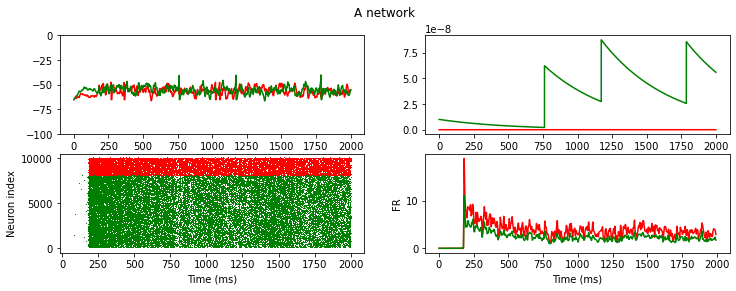

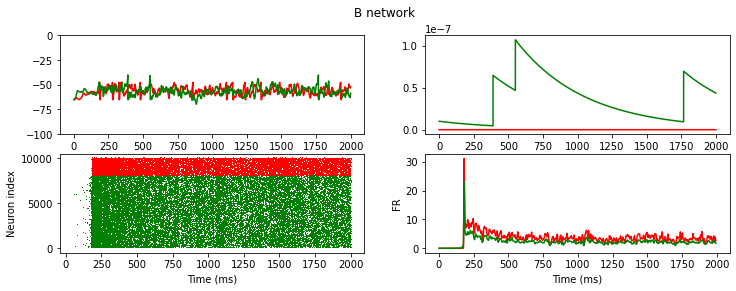

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
import scipy.fftpack

def bin_array(array, BIN, time_array):
    N0 = int(BIN/(time_array[1]-time_array[0]))
    N1 = int((time_array[-1]-time_array[0])/BIN)
    return array[:N0*N1].reshape((N1,N0)).mean(axis=1)


start_scope()
DT=0.1 #fenetre de temps à modifier 
defaultclock.dt = DT*ms
N1 = 2000#2000
N2 = 8000#8000

TotTime=2000
duration = TotTime*ms



eqs='''
dv/dt = (-GsynE*(v-Ee)-GsynI*(v-Ei)-gl*(v-El)+ gl*Dt*exp((v-Vt)/Dt)-w + Is)/Cm : volt (unless refractory)
dw/dt = (a*(v-El)-w)/tau_w:ampere
dGsynI/dt = -GsynI/Tsyn : siemens
dGsynE/dt = -GsynE/Tsyn : siemens
Is:ampere
Cm:farad
gl:siemens
El:volt
a:siemens
tau_w:second
Dt:volt
Vt:volt
Ee:volt
Ei:volt
Tsyn:second
'''

# Populations----------------------------------------------------------------------------------

############################ First Adex FS-RS population 1-2 ####################################
# Population 1 - FS
b1 = 0.0*pA # no adaptation for FS 
G1 = NeuronGroup(N1, eqs, threshold='v > -47.5*mV', reset='v = -65*mV', refractory='5*ms', method='heun')
#
#init:
G1.v = -65*mV
G1.w = 0.0*pA
G1.GsynI=0.0*nS
G1.GsynE=0.0*nS
#parameters
G1.Cm = 200.*pF
G1.gl = 10.*nS
G1.El = -70.*mV
G1.Vt = -48.*mV
G1.Dt = 0.5*mV
G1.tau_w = 1.0*ms
G1.a = 0.0*nS
G1.Is = 0.0 #[0.0 for i in range(N1)]*nA

G1.Ee=0.*mV
G1.Ei=-80.*mV
G1.Tsyn=5.*ms

# Population 2 - RS
b2 = 60.*pA #adaptation for RS (slow adaptation or spike frequency adapatation)
G2 = NeuronGroup(N2, eqs, threshold='v > -40.0*mV', reset='v = -65*mV; w += b2', refractory='5*ms',  method='heun')
G2.v = -65.*mV
G2.w = 10.0*pA
G2.GsynI=0.0*nS
G2.GsynE=0.0*nS
G2.Cm = 200.*pF
G2.gl = 10.*nS
G2.El = -65.*mV
G2.Vt = -50.*mV
G2.Dt = 2.*mV
G2.tau_w = 500.*ms
G2.a = 0.*nS
G2.Is = 0.0*nA #2.50*nA #[0.0 for i in range(N2)]*nA
#G2.Is[0]=0.*nA

G2.Ee=0.*mV
G2.Ei=-80.*mV
G2.Tsyn=5.*ms


# external drive-------------------------------------------------------------------------- Poisson distribution because of complex pattern of firing rate population spikes (fundamental hypothesis of the AdEx and because of chaos theory).

P_edA=PoissonGroup(8000, .8*Hz) #see what happens with external input on A network, compare witgh same input on B at the same time 

# connections-----------------------------------------------------------------------------

Qi=5.0*nS
Qe=1.*nS

prbC= 0.05 #0.05 => 5% of connectivity probability to explain (admit now, in research), "threshold to observe realisftic neural dynamics"
prbC2=0.05
S_12 = Synapses(G1, G2, on_pre='GsynI_post+=Qi') #'v_post -= 1.*mV'
S_12.connect('i!=j', p=prbC2)

S_11 = Synapses(G1, G1, on_pre='GsynI_post+=Qi')
S_11.connect('i!=j',p=prbC2)

S_21 = Synapses(G2, G1, on_pre='GsynE_post+=Qe')
S_21.connect('i!=j',p=prbC)

S_22 = Synapses(G2, G2, on_pre='GsynE_post+=Qe')
S_22.connect('i!=j', p=prbC)

#Synaptic Connections with external input and the inhibitors/excitators cells in B network 
#Si_inex2=[a for a in S_ed_inB.i] # inibitors-external input from neuron i
#Sj_inex2=[a for a in S_ed_inB.j] # inibitors-external input from neuron j
#Si_exex2=[a for a in S_ed_exB.i] # excitators-external input from neuron i
#Sj_exex2=[a for a in S_ed_exB.j] # excitators-external input from neuron j


############## #synapses from external drive to both populations of A network:
S_ed_inA = Synapses(P_edA, G1, on_pre='GsynE_post+=Qe') # Synapses receives the extrernal input in the A network, incremental quantal Qe because the external input is excitator 
#S_ed_inA.connect(i=Si_inex2, j=Sj_inex2) # synaptic connections of inibitors-external input of inibitors cells synapses connections
S_ed_inA.connect(p=prbC)

S_ed_exA = Synapses(P_edA, G2, on_pre='GsynE_post+=Qe')
S_ed_exA.connect(p=prbC)
#S_ed_exA.connect(i=Si_exex2, j=Sj_exex2) # synaptic connections of excitators-external input of inibitors cells synapses connections



Vtt=1 #Vtt => mean threshold of the membran potential of each adex

M1G1 = SpikeMonitor(G1)
M2G1 = StateMonitor(G1, 'v', record=range(Vtt))
M3G1 = StateMonitor(G1, 'w', record=range(Vtt))
M4G1 = StateMonitor(G1, 'GsynE', record=range(Vtt)) #monitoring of the synchronous conductance of the FS in G1
M5G1 = StateMonitor(G1, 'GsynI', record=range(Vtt)) #monitoring of the synchronous conductance of the RS in G1
FRG1 = PopulationRateMonitor(G1)

M1G2 = SpikeMonitor(G2)
M2G2 = StateMonitor(G2, 'v', record=range(Vtt))
M3G2 = StateMonitor(G2, 'w', record=range(Vtt))
M4G2 = StateMonitor(G2, 'GsynE', record=range(Vtt))
M5G2 = StateMonitor(G2, 'GsynI', record=range(Vtt))
FRG2 = PopulationRateMonitor(G2)

######################################################## Second ADEX FS-RS ##########################################################
##################################################################################################################

# Population 3 - FS
b3 = 0.0*pA
G3 = NeuronGroup(N1, eqs, threshold='v > -47.5*mV', reset='v = -65*mV', refractory='5*ms', method='heun')
#init:
G3.v = -65*mV
G3.w = 0.0*pA
G3.GsynI=0.0*nS
G3.GsynE=0.0*nS
#parameters
G3.Cm = 200.*pF
G3.gl = 10.*nS
G3.El = -70.*mV
G3.Vt = -48.*mV
G3.Dt = 0.5*mV
G3.tau_w = 1.0*ms
G3.a = 0.0*nS
G3.Is = 0.0 #[0.0 for i in range(N1)]*nA

G3.Ee=0.*mV
G3.Ei=-80.*mV
G3.Tsyn=5.*ms

# Population 4 - RS
b4 = 60.*pA
G4 = NeuronGroup(N2, eqs, threshold='v > -40.0*mV', reset='v = -65*mV; w += b4', refractory='5*ms',  method='heun')
G4.v = -65.*mV
G4.w = 10.0*pA
G4.GsynI=0.0*nS
G4.GsynE=0.0*nS
G4.Cm = 200.*pF
G4.gl = 10.*nS
G4.El = -65.*mV
G4.Vt = -50.*mV
G4.Dt = 2.*mV
G4.tau_w = 500.*ms
G4.a = 0.*nS
G4.Is = 0.0*nA #2.50*nA #[0.0 for i in range(N2)]*nA
#G2.Is[0]=0.*nA

G4.Ee=0.*mV
G4.Ei=-80.*mV
G4.Tsyn=5.*ms

# external drive--------------------------------------------------------------------------

P_edB=PoissonGroup(8000, .8*Hz) #here we have only the external input in B network 

# connections-----------------------------------------------------------------------------

Qi=5.0*nS
Qe=1.0*nS

"""
#a mettre en commentaire pour test (structure pareille)
Si34=[a for a in S_12.i]
Sj34=[a for a in S_12.j]
Si33=[a for a in S_11.i]
Sj33=[a for a in S_11.j]
Si43=[a for a in S_21.i]
Sj43=[a for a in S_21.j]
Si44=[a for a in S_22.i]
Sj44=[a for a in S_22.j]
"""

prbC= 0.05 #0.05
prbC2=0.05
S_34 = Synapses(G3, G4, on_pre='GsynI_post+=Qi') #'v_post -= 1.*mV')
S_34.connect('i!=j', p=prbC)

S_33 = Synapses(G3, G3, on_pre='GsynI_post+=Qi')
S_33.connect('i!=j', p=prbC)

S_43 = Synapses(G4, G3, on_pre='GsynE_post+=Qe')
S_43.connect('i!=j', p=prbC)

S_44 = Synapses(G4, G4, on_pre='GsynE_post+=Qe')
S_44.connect('i!=j', p=prbC)

'''
#Synaptic Connections with external input and the inhibitors/excitators cells in A network 
Si_inex=[a for a in S_ed_inA.i] # inibitors-external input from neuron i
Sj_inex=[a for a in S_ed_inA.j] # inibitors-external input from neuron j
Si_exex=[a for a in S_ed_exA.i] # excitators-external input from neuron i
Sj_exex=[a for a in S_ed_exA.j] # excitators-external input from neuron j
'''


####### display Synaptic Connections with external input and the inhibitors/excitators cells in B network 
S_ed_inB = Synapses(P_edB, G3, on_pre='GsynE_post+=Qe')
#S_ed_inB.connect(i=Si_inex, j=Sj_inex) # synaptic connections of inibitors-external input of inibitors cells synapses connections in B
S_ed_inB.connect(p=prbC)


S_ed_exB = Synapses(P_edB, G4, on_pre='GsynE_post+=Qe')
#S_ed_exB.connect(i=Si_exex, j=Sj_exex) # synaptic connections of excitators-external input of excitatory cells synapses connections in B
S_ed_exB.connect(p=prbC)


Vtt=1

M1G3 = SpikeMonitor(G3)
M2G3 = StateMonitor(G3, 'v', record=range(Vtt))
M3G3 = StateMonitor(G3, 'w', record=range(Vtt))
M4G3 = StateMonitor(G3, 'GsynE', record=range(Vtt))
M5G3 = StateMonitor(G3, 'GsynI', record=range(Vtt))
FRG3 = PopulationRateMonitor(G3)

M1G4 = SpikeMonitor(G4)
M2G4 = StateMonitor(G4, 'v', record=range(Vtt))
M3G4 = StateMonitor(G4, 'w', record=range(Vtt))
M4G4 = StateMonitor(G4, 'GsynE', record=range(Vtt))
M5G4 = StateMonitor(G4, 'GsynI', record=range(Vtt))
FRG4 = PopulationRateMonitor(G4)


##################################################################################################################
##################################################################################################################


prbCBA=0.05

#Synaptic Connection from B (G3-G4) A (G1-G2) to  synapses 
S_ABii = Synapses(G3, G1, on_pre='GsynI_post+=Qi')
S_ABii.connect('i!=j',p=prbCBA)

S_ABie = Synapses(G3, G2, on_pre='GsynI_post+=Qi')
S_ABie.connect('i!=j',p=prbCBA)



S_ABei = Synapses(G4, G1, on_pre='GsynE_post+=Qe')
S_ABei.connect('i!=j',p=prbCBA)

S_ABee = Synapses(G4, G2, on_pre='GsynE_post+=Qe')
S_ABee.connect('i!=j',p=prbCBA)



##################################################################################################################
##################################################################################################################


#Synaptic Connection from A (G1-G2) to  B (G3-G4) synapses 
prbCAB=0.05
#
S_BAii = Synapses(G1, G3, on_pre='GsynI_post+=Qi')
S_BAii.connect('i!=j',p=prbCAB)
#
S_BAie = Synapses(G1, G4, on_pre='GsynI_post+=Qi')
S_BAie.connect('i!=j',p=prbCAB)
#
#
#
S_BAei = Synapses(G2, G3, on_pre='GsynE_post+=Qe')
S_BAei.connect('i!=j',p=prbCAB)
#
S_BAee = Synapses(G2, G4, on_pre='GsynE_post+=Qe')
S_BAee.connect('i!=j',p=prbCAB)



##################################################################################################################
##################################################################################################################

print('--##Start simulation##--')
run(duration)
print('--##End simulation##--')


# Plots -------------------------------------------------------------------------------


RasG1 = np.array([M1G1.t/ms, [i+N2 for i in M1G1.i]])
RasG2 = np.array([M1G2.t/ms, M1G2.i])


LVG1=[]
LwG1=[]
LVG2=[]
LwG2=[]

LgseG1=[]
LgsiG1=[]
LgseG2=[]
LgsiG2=[]

for a in range(Vtt):
    LVG1.append(array(M2G1[a].v/mV))
    LwG1.append(array(M3G1[a].w/mamp))
    LVG2.append(array(M2G2[a].v/mV))
    LwG2.append(array(M3G2[a].w/mamp))
    LgseG1.append(array(M4G1[a].GsynE/nS))
    LgsiG1.append(array(M5G1[a].GsynI/nS))
    LgseG2.append(array(M4G2[a].GsynE/nS))
    LgsiG2.append(array(M5G2[a].GsynI/nS))


BIN=5
time_array = np.arange(int(TotTime/DT))*DT



LfrG2=np.array(FRG2.rate/Hz)
TimBinned,popRateG2=bin_array(time_array, BIN, time_array),bin_array(LfrG2, BIN, time_array)

LfrG1=np.array(FRG1.rate/Hz)
TimBinned,popRateG1=bin_array(time_array, BIN, time_array),bin_array(LfrG1, BIN, time_array)



Lt1G1=array(M2G1.t/ms)
Lt2G1=array(M3G1.t/ms)
Lt1G2=array(M2G2.t/ms)
Lt2G2=array(M3G2.t/ms)



fig=plt.figure(figsize=(12,4))
fig.suptitle('A network')
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)

for a in range(len(LVG1)):
    ax1.plot(Lt1G1, LVG1[a],'r')
    ax2.plot(Lt2G1, LwG1[a],'r')
    ax1.plot(Lt1G2, LVG2[a],'g')
    ax2.plot(Lt2G2, LwG2[a],'g')


ax1.set_ylim([-100, 0])
ax3=fig.add_subplot(223)
ax3.plot(RasG1[0], RasG1[1], ',r')
ax3.plot(RasG2[0], RasG2[1], ',g')

ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Neuron index')
ax4=fig.add_subplot(224)
ax4.plot(TimBinned,popRateG1, 'r')
ax4.plot(TimBinned,popRateG2, 'g')

ax4.set_xlabel('Time (ms)')
ax4.set_ylabel('FR')




#######################################################
RasG3 = np.array([M1G3.t/ms, [i+N2 for i in M1G3.i]])
RasG4 = np.array([M1G4.t/ms, M1G4.i])


LVG3=[]
LwG3=[]
LVG4=[]
LwG4=[]

LgseG3=[]
LgsiG3=[]
LgseG4=[]
LgsiG4=[]

for a in range(Vtt):
    LVG3.append(array(M2G3[a].v/mV))
    LwG3.append(array(M3G3[a].w/mamp))
    LVG4.append(array(M2G4[a].v/mV))
    LwG4.append(array(M3G4[a].w/mamp))
    LgseG3.append(array(M4G3[a].GsynE/nS))
    LgsiG3.append(array(M5G3[a].GsynI/nS))
    LgseG4.append(array(M4G4[a].GsynE/nS))
    LgsiG4.append(array(M5G4[a].GsynI/nS))


BIN=5
time_array = np.arange(int(TotTime/DT))*DT



LfrG4=np.array(FRG4.rate/Hz)
TimBinned,popRateG4=bin_array(time_array, BIN, time_array),bin_array(LfrG4, BIN, time_array)

LfrG3=np.array(FRG3.rate/Hz)
TimBinned,popRateG3=bin_array(time_array, BIN, time_array),bin_array(LfrG3, BIN, time_array)



Lt1G3=array(M2G3.t/ms)
Lt2G3=array(M3G3.t/ms)
Lt1G4=array(M2G4.t/ms)
Lt2G4=array(M3G4.t/ms)



figB=plt.figure(figsize=(12,4))
figB.suptitle('B network')
ax1B=figB.add_subplot(221)
ax2B=figB.add_subplot(222)

for a in range(len(LVG3)):
    ax1B.plot(Lt1G3, LVG3[a],'r')
    ax2B.plot(Lt2G3, LwG3[a],'r')
    ax1B.plot(Lt1G4, LVG4[a],'g')
    ax2B.plot(Lt2G4, LwG4[a],'g')


ax1B.set_ylim([-100, 0])
ax3B=figB.add_subplot(223)
ax3B.plot(RasG3[0], RasG3[1], ',r')
ax3B.plot(RasG4[0], RasG4[1], ',g')

ax3B.set_xlabel('Time (ms)')
ax3B.set_ylabel('Neuron index')
ax4B=figB.add_subplot(224)
ax4B.plot(TimBinned,popRateG3, 'r')
ax4B.plot(TimBinned,popRateG4, 'g')

ax4B.set_xlabel('Time (ms)')
ax4B.set_ylabel('FR')


plt.show()

In [74]:
arr=[popRateG1,popRateG2,LwG2,LVG1,LVG2,LfrG1,LfrG2,TimBinned,time_array]
np.save('2pop_data.npy', arr)
print("Your array has been saved to 2pop_data.npy")

WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
 [py.warnings]


Your array has been saved to 2pop_data.npy


In [76]:
data = np.load('2pop_data.npy',allow_pickle=True)
print("The data is:")
print(data)

The data is:
[array([0. , 5.2, 8.2, ..., 7.5, 5.7, 6.7])
 array([0.   , 0.025, 0.225, ..., 0.1  , 0.025, 0.025])
 list([array([0.00000000e+00, 2.66666667e-12, 5.31982370e-12, ...,
       4.90407489e-08, 4.90411934e-08, 4.90416527e-08])])
 list([array([-65.        , -65.        , -65.        , ..., -55.85157939,
       -55.70299375, -55.56038117])])
 list([array([-65.        , -65.04999447, -65.09974044, ..., -61.07262722,
       -61.01745606, -60.96622138])])
 array([0., 0., 0., ..., 0., 5., 0.]) array([0., 0., 0., ..., 0., 0., 0.])
 array([2.45000e+00, 7.45000e+00, 1.24500e+01, ..., 9.98245e+03,
       9.98745e+03, 9.99245e+03])
 array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 9.9997e+03, 9.9998e+03,
       9.9999e+03])]


In [77]:
popRateG1=data[0]
popRateG2=data[1]
LwG2=data[2]
LVG1=data[3]
LVG2=data[4]
LfrG1=data[5]
LfrG2=data[6]

In [ ]:
trains = M1G1.spike_trains()
isi_mu = full(num_tau, nan)*second
isi_std = full(num_tau, nan)*second
for idx in range(num_tau):
    train = diff(trains[idx])
    if len(train)>1:
        isi_mu[idx] = mean(train)
        isi_std[idx] = std(train)
errorbar(tau_range/ms, isi_mu/ms, yerr=isi_std/ms)
xlabel(r'$\tau$ (ms)')
ylabel('Interspike interval (ms)');

In [151]:
tRas=[RasG1[0],RasG2[0]]
iRas=[RasG1[1],RasG2[1]]

In [152]:
from neural_network_dynamics import *

In [155]:
from itertools import combinations # for cross correlations
from scipy.stats import skew
# for smoothing
from scipy.ndimage.filters import gaussian_filter1d

from neural_network_dynamics.analyz.processing.signanalysis import get_acf_time

def get_CV_spiking(n):
    for n in range(0,1):
        ispikes, tspikes =iRas[n],tRas[n] 
        CV = []
        for i in np.unique(ispikes):
            tspikes_i = tspikes_inh[np.argwhere(ispikes==i).flatten()]
            isi = np.diff(tspikes_i)
        if len(isi)>2:
            CV.append(np.std(isi)/np.mean(isi))
    if len(CV)>1:
        return np.array(CV).mean()
    else:
        return 0
'''
def get_synchrony_of_spiking(data, pop='Exc',
                             Tbin=2, Nmax_pairs=4000,
                             seed=23, tzoom=[-np.inf, np.inf]):
    """see Kumar et al. 2008

    we introduce a limiting number of pairs for fast computation"""

    np.random.seed(seed)

    n, Ntot = 0, 0
    while str(n) in data.keys():
        if (data[str(n)]['name']==pop):
            Ntot = int(data[str(n)]['N'])
        n+=1
    if Ntot==0:
        print('key not recognized in neural_net_dyn.macro_quantities.get_synchrony_of_spiking !!')

    ispikes, tspikes = data['iRASTER_'+pop], data['tRASTER_'+pop]
    # in case we focus on a subset of the temporal dynamics (none by default)
    cond = (tspikes>tzoom[0]) & (tspikes<tzoom[1])
    ispikes, tspikes = ispikes[cond], tspikes[cond]
    
    ispikes_unique = np.unique(ispikes)
    new_t = np.arange(int(data['tstop']/Tbin)+5)*Tbin

    if len(ispikes_unique)>3:
        # if there are at least two couples
        couples = list(combinations(ispikes_unique, r=2))
        Nmax_pairs = min([len(couples), Nmax_pairs])
        rdm_picks = np.random.choice(range(len(couples)), Nmax_pairs)

        SYNCH = []
        for r in range(Nmax_pairs):
            i, j = couples[rdm_picks[r]]
            tspikes_i = tspikes[np.argwhere(ispikes==i).flatten()]
            tspikes_j = tspikes[np.argwhere(ispikes==j).flatten()]
            spk_train_i, _ = np.histogram(tspikes_i, bins=new_t)
            spk_train_j, _ = np.histogram(tspikes_j, bins=new_t)
            SYNCH.append(np.corrcoef(spk_train_i, spk_train_j)[0,1])
        return np.array(SYNCH).mean()
    else:
        return 0
'''    

'\ndef get_synchrony_of_spiking(data, pop=\'Exc\',\n                             Tbin=2, Nmax_pairs=4000,\n                             seed=23, tzoom=[-np.inf, np.inf]):\n    """see Kumar et al. 2008\n\n    we introduce a limiting number of pairs for fast computation"""\n\n    np.random.seed(seed)\n\n    n, Ntot = 0, 0\n    while str(n) in data.keys():\n        if (data[str(n)][\'name\']==pop):\n            Ntot = int(data[str(n)][\'N\'])\n        n+=1\n    if Ntot==0:\n        print(\'key not recognized in neural_net_dyn.macro_quantities.get_synchrony_of_spiking !!\')\n\n    ispikes, tspikes = data[\'iRASTER_\'+pop], data[\'tRASTER_\'+pop]\n    # in case we focus on a subset of the temporal dynamics (none by default)\n    cond = (tspikes>tzoom[0]) & (tspikes<tzoom[1])\n    ispikes, tspikes = ispikes[cond], tspikes[cond]\n    \n    ispikes_unique = np.unique(ispikes)\n    new_t = np.arange(int(data[\'tstop\']/Tbin)+5)*Tbin\n\n    if len(ispikes_unique)>3:\n        # if there are at le

In [158]:
get_CV_spiking(1)

0

In [159]:
np.array(CV).mean()

0.8935142124408237

In [1]:
fig, axs = plt.subplots(2, 1, figsize=(4, 3))
sp = iRas
times = tRas
nNeurons = max(sp) + 1
nSpikes = len(sp)

spiketimes = {}
for n in range(nNeurons):
    ts = list(times[(np.where(sp == n))])
    ts = [t for t in ts if t > 500 * ms]
    spiketimes[n] = ts
isi_stds = []
isi_cvs = []
for n in range(nNeurons):
    isi_std = np.std(np.diff(spiketimes[n]))
    isi_cv = np.std(np.diff(spiketimes[n])) / np.mean(np.diff(spiketimes[n]))
        #plt.scatter(n, np.std(np.diff(spiketimes[n])))
    isi_stds.append(isi_std)  
    isi_cvs.append(isi_cv)
        
meanFiringRates = []
for n in range(nNeurons):
    meanFiringRates.append(1 / np.mean(np.diff(spiketimes[n])))
        
    

axs[0].hist(isi_cvs, bins=15, label=label, alpha=0.9, edgecolor='black',);
axs[1].hist(meanFiringRates, bins=10, label=label, alpha=0.9, edgecolor='black',);
    
for k in range(1):
    leg = axs[k].legend(loc=1)
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
   
for k in range(2):
    axs[k].spines['right'].set_visible(False)
    axs[k].spines['top'].set_visible(False)
    axs[k].spines['bottom'].set_visible(False)
    axs[k].spines['left'].set_visible(False)
axs[0].set_xticks([0, 0.5, 1.0])
axs[0].set_yticks([0, 10, 20])

axs[0].set_xlim(0, 1.6)
axs[0].set_xlabel("CV$_{ISI}$")
axs[1].set_xlabel("Spike counts [$s^{-1}$]")

#axs[0].set_ylabel("Neuron count")
axs[1].set_ylabel("Neuron count")

plt.subplots_adjust(hspace=0.5)

NameError: name 'plt' is not defined

### Draw distribution

0.6292765578596433 0.1362075120042022 2.02899981520983 0.14593001260338362 0.6292765578596433 0.14593001260338362 2.02899981520983 0.3074187997331523


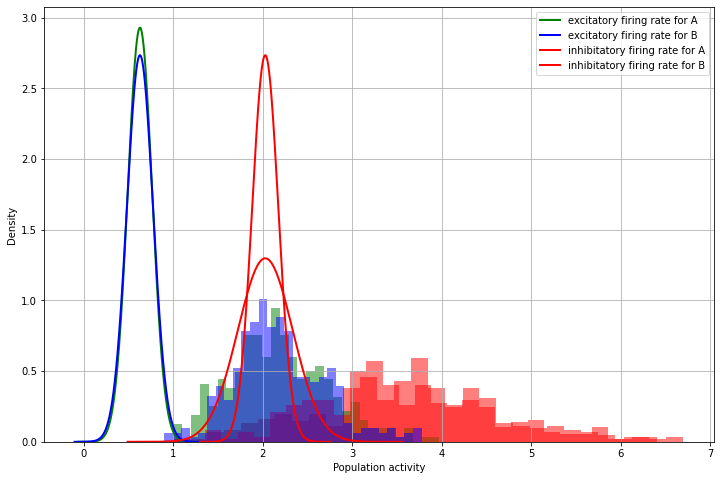

In [57]:
import scipy.stats

def gaussian(x,mean,std):
    return 1/(np.sqrt(2*math.pi*std**2))*math.exp(-(x-mean)**2/(2*std**2))

plt.figure(figsize=(12,8))

'''Remove transient'''

ST_popRateG1=popRateG1[int(len(popRateG1)/5)::] 
ST_popRateG2=popRateG2[int(len(popRateG2)/5)::]
ST_popRateG3=popRateG3[int(len(popRateG3)/5)::] 
ST_popRateG4=popRateG4[int(len(popRateG4)/5)::]

plt.hist(ST_popRateG1, color='r',density= True, bins=30, alpha=0.5)
plt.hist(ST_popRateG2, color='g',density=True, bins=30, alpha=0.5)
plt.hist(ST_popRateG3, color='r',density= True, bins=30, alpha=0.5)
plt.hist(ST_popRateG4, color='b',density=True, bins=30, alpha=0.5)


mean_RS1=final_state[0]
std_RS1=np.sqrt(final_state[4])

mean_RS2=final_state[1]
std_RS2=np.sqrt(final_state[11])

mean_FS1=final_state[2]
std_FS1=np.sqrt(final_state[16])

mean_FS2=final_state[3]
std_FS2=np.sqrt(final_state[19])


print(mean_RS1,std_RS1,mean_FS1,std_FS1,mean_RS2,std_RS2,mean_FS2,std_FS2)

x_min_RS1=mean_RS1-5*std_RS1 #x_min_RS=mean_RS-5*std_RS
x_max_RS1=mean_RS1+5*std_RS1

x_min_RS2=mean_RS2-5*std_RS2 #x_min_RS=mean_RS-5*std_RS
x_max_RS2=mean_RS2+5*std_RS2

x_min_FS1=mean_FS1-5*std_FS1
x_max_FS1=mean_FS1+5*std_FS1

x_min_FS2=mean_FS2-5*std_FS2
x_max_FS2=mean_FS2+5*std_FS2

x_RS1 = np.linspace(x_min_RS1, x_max_RS1, 1000)
x_FS1 = np.linspace(x_min_FS1, x_max_FS1, 1000)
x_RS2 = np.linspace(x_min_RS2, x_max_RS2, 1000)
x_FS2 = np.linspace(x_min_FS2, x_max_FS2, 1000)


Distrib_RS1=[]
Distrib_FS1=[]
Distrib_RS2=[]
Distrib_FS2=[]


for i in range(len(x_RS1)):
    Distrib_RS1.append(gaussian(x_RS1[i],mean_RS1,std_RS1))
    Distrib_RS2.append(gaussian(x_RS2[i],mean_RS2,std_RS2))
    Distrib_FS1.append(gaussian(x_FS1[i],mean_FS1,std_FS1))
    Distrib_FS2.append(gaussian(x_FS2[i],mean_FS2,std_FS2))


plt.plot(x_RS1,Distrib_RS1,color='g',lw=2,label='excitatory firing rate for A')
plt.plot(x_RS2,Distrib_RS2,color='b',lw=2,label='excitatory firing rate for B')
plt.plot(x_FS1,Distrib_FS1,color='r',lw=2, label='inhibitatory firing rate for A')
plt.plot(x_FS2,Distrib_FS2,color='r',lw=2, label='inhibitatory firing rate for B')
                             
plt.xlabel("Population activity")
plt.grid(True)
plt.ylabel("Density")
plt.legend()
plt.show()

In [43]:
print(x_max_RS)

0.7664898782012017


In [58]:
x_transp=np.transpose(x_trace_RS)
TF_transp=np.transpose(TF_trace_RS)
ve1=x_transp[0]#[1000:] # remove first 10000 elements
ve2=x_transp[1]#[1000:]
vi1=x_transp[2]#[1000:]
vi2=x_transp[3]#[1000:]
#cie=x_transp[4]#[1000:]
#cii=np.sqrt(x_transp[5])#[1000:]
w1=x_transp[20]
w2=x_transp[21]
#cv_i=cee/ve
#cv_e=cii/vi
#print(cee[:1000],cii[:1000])

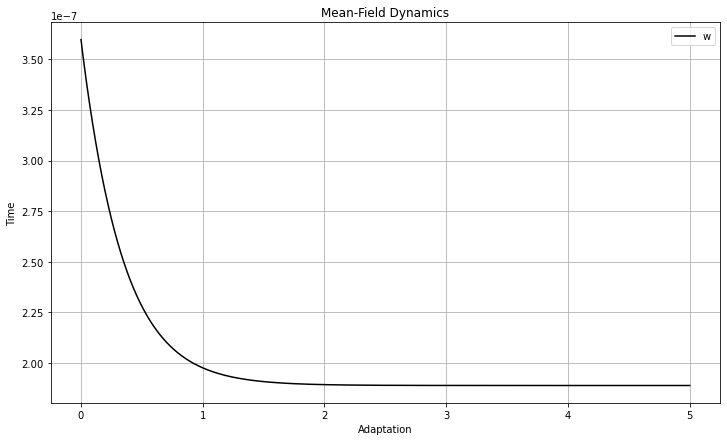

In [59]:
plt.figure(figsize=(12, 7))
#plt.plot(t_trace, ve, color="green", label="excitatory firing rate")
#plt.plot(t_trace, vi, color="red", label="inhibitory firing rate")
#plt.plot(TimBinned/1000,  popRateG2, color="green",ls="--", label="excitatory firing rate")
#plt.plot(TimBinned/1000, popRateG1, color="red",ls="--", label="inhibitory firing rate")
#plt.plot(t_trace, cee, color="blue", label="excitory cee")
#plt.plot(t_trace, cii, color="purple", label="inhibitory cii")
#plt.plot(t_trace, cei, color="yellow", label="cei")
#plt.plot(t_trace, cie, color="orange", label="cie")
plt.plot(t_trace,w1*1e4,color="black",label="w")
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red", ls="--")
#plt.plot(t_trace,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Adaptation")
plt.grid(True)
plt.ylabel("Time")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(-20,20)
#plt.xlim(0,0.1)
plt.show()

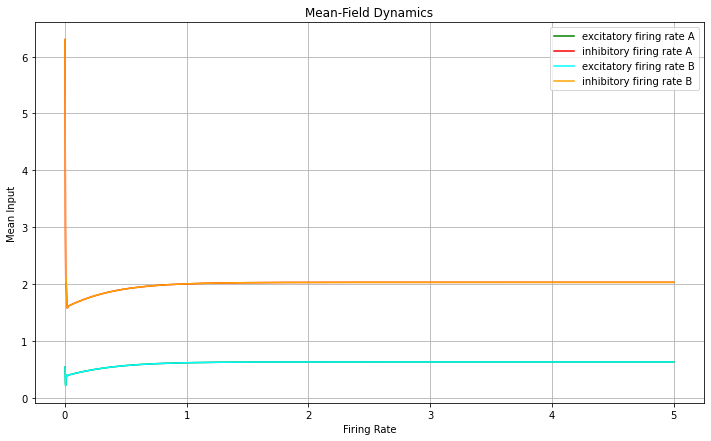

In [60]:
plt.figure(figsize=(12, 7))
plt.plot(t_trace, ve1, color="green", label="excitatory firing rate A")
plt.plot(t_trace, vi1, color="red", label="inhibitory firing rate A")
plt.plot(t_trace, ve2, color="cyan", label="excitatory firing rate B")
plt.plot(t_trace, vi2, color="orange", label="inhibitory firing rate B")
#plt.plot(TimBinned/1000,  popRateG2, color="green",ls="--", label="excitatory firing rate")
#plt.plot(TimBinned/1000, popRateG1, color="red",ls="--", label="inhibitory firing rate")
#plt.plot(t_trace, cee, color="blue", label="excitory cee")
#plt.plot(t_trace, cii, color="purple", label="inhibitory cii")
#plt.plot(t_trace, cei, color="yellow", label="cei")
#plt.plot(t_trace, cie, color="orange", label="cie")
#plt.plot(t_trace,w2*1e5,color="black",label="w")
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red", ls="--")
#plt.plot(t_trace,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Firing Rate")
plt.grid(True)
plt.ylabel("Mean Input")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(-20,20)
#plt.xlim(0,0.1)
plt.show()

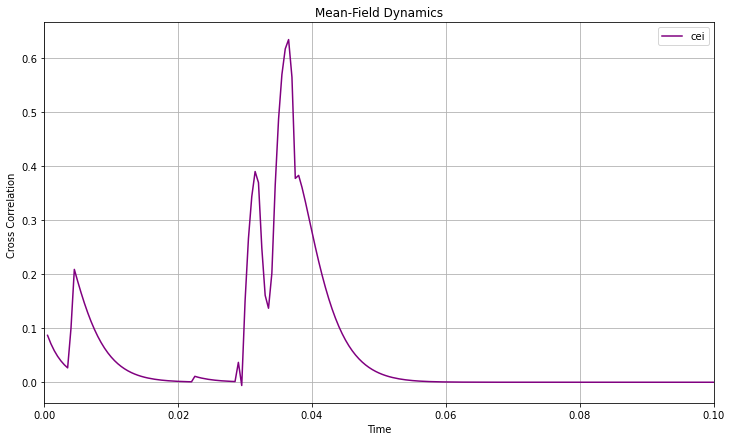

In [168]:
plt.figure(figsize=(12, 7))
#plt.plot(t_trace, ve, color="green", label="excitory firing rate")
#plt.plot(t_trace, vi, color="red", label="inhibitory firing rate")
#plt.plot(t_trace, cee, color="blue", label="excitory cee")
#plt.plot(t_trace, cii, color="purple", label="inhibitory cii")
plt.plot(t_trace, cei*1e-4, color="purple", label="cei")
#plt.plot([-t_trace,t_trace], cie*1e-4, color="orange", label="cie")
#plt.plot(t_trace,w2*1e5,color="black",label="w")
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red", ls="--")
#plt.plot(t_trace,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Time")
plt.grid(True)
plt.ylabel("Cross Correlation ")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(0,6000)
plt.xlim(0,0.1)
plt.show()

### Now... MAKE SOME NOISE !!!

##### ...(define noise functions and parameters)

In [61]:
def Ornstein_U_list(xi_0,dt,tot_time,tau):
    
    for i in np.arange(0,tot_time,dt):
        xi_0+=-dt*xi_0/tau+np.sqrt(dt)*np.random.randn()
        
###   To integrate in the MF, it needs to be written as a function

def OU_func_list(t,O_U_list):
    return O_U_list[t]

def Ornstein_func(xi_0,dt,tau):
    
    return xi_0-dt*xi_0/tau+np.sqrt(dt)*np.random.randn()
    

In [51]:
np.random.seed(10)
import datetime ### To keep track of time, might be useful, little bit like a watch
x0=np.ones(params['numb_var'])*1e-5 
x0[0]=0.6 #ve1 exp 
x0[1]=0.6 #ve2 exp
x0[2]=7.0 #vi1 exp 
x0[3]=7.0 #vi2 exp
x0[20]=x0[0]*60e-12 
x0[21]=x0[1]*60e-12 #w exp
print(x0)
time=0
t_trace2=[]
#T=0.005
#x_trace_aWITHTAU=[]
x_trace_RS_with_noise=[]
TF_trace_RS_with_noise=[]

drive=[]
params['tstep']=1e-4
params['T']=0.005


xi_exc=0 ## O_U process
xi_inh=0


print(x0)
time=0
    
for i in np.arange(0,10,params['tstep']):
    TF_inst= Euler_method_General(x0,params,time,MeanField_dN_dp_Hybrid_noise)
    
    xi_exc=Ornstein_func(xi_exc,params['tstep'],5e-4)
    xi_inh=Ornstein_func(xi_inh,params['tstep'],5e-4)

    params['ext_inp'][0]=2.0+10.5*xi_exc    
    params['ext_inp'][1]=2.0+10.5*xi_inh
    
    if (i%0.5==0):
        print('i = ', i, '\n')
        print('time : ', datetime.datetime.now(), ' \n \n')
    time+=params['tstep']
    t_trace2.append(time)
    
    x_trace_RS_with_noise.append(x0.copy())
    TF_trace_RS_with_noise.append(TF_inst.copy())
    drive.append(params['ext_inp'])
    

[6.0e-01 6.0e-01 7.0e+00 7.0e+00 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05
 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05
 1.0e-05 1.0e-05 3.6e-11 3.6e-11]
[6.0e-01 6.0e-01 7.0e+00 7.0e+00 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05
 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05
 1.0e-05 1.0e-05 3.6e-11 3.6e-11]
i =  0.0 

time :  2021-08-30 16:06:57.247639  
 

i =  0.5 

time :  2021-08-30 16:08:41.321960  
 

i =  1.0 

time :  2021-08-30 16:10:30.427121  
 

i =  1.5 

time :  2021-08-30 16:12:21.456843  
 

i =  2.0 

time :  2021-08-30 16:14:17.647225  
 

i =  2.5 

time :  2021-08-30 16:16:08.364643  
 

i =  3.0 

time :  2021-08-30 16:17:56.149496  
 

i =  3.5 

time :  2021-08-30 16:19:53.308622  
 



KeyboardInterrupt: 

In [62]:
final_state2=x_trace_RS_with_noise[-1]
print(final_state2)

[7.33008478e-001 8.49897813e-001 2.06540388e+000 6.58184887e-004
 3.31108366e+005 1.08547795e+006 5.77308231e+003 4.12258094e+003
 1.08547795e+006 3.52320493e+006 1.85507598e+004 1.31350826e+004
 5.77308231e+003 1.85507598e+004 9.82785284e+001 6.70215974e+001
 4.12258094e+003 1.31350826e+004 6.70215974e+001 4.62422239e+001
 1.46409581e-011 1.97626258e-323]


0.2864307443185462 0.18225086131473026 5.417374942985087 0.6930979781648455


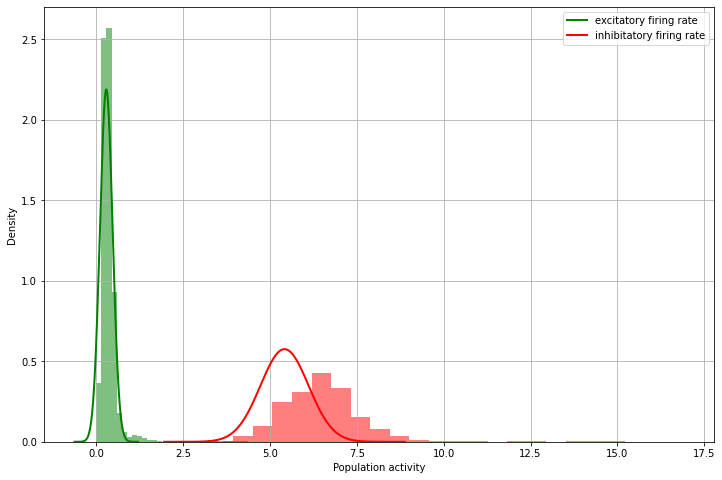

In [197]:
import scipy.stats

def gaussian(x,mean,std):
    return 1/(np.sqrt(2*math.pi*std**2))*math.exp(-(x-mean)**2/(2*std**2))



plt.figure(figsize=(12,8))

'''Remove transient'''

ST_popRateG1=popRateG1[int(len(popRateG1)/10000)::] 
ST_popRateG2=popRateG2[int(len(popRateG2)/10000)::]

plt.hist(ST_popRateG1, color='r',density=True,bins=30, alpha=0.5)
plt.hist(ST_popRateG2, color='g',density=True,bins=30, alpha=0.5)


mean_RS=final_state2[0]
std_RS=np.sqrt(final_state2[2])

mean_FS=final_state2[1]
std_FS=np.sqrt(final_state2[5])

print(mean_RS,std_RS,mean_FS,std_FS)

x_min_RS=mean_RS-5*std_RS #x_min_RS=mean_RS-5*std_RS
x_max_RS=mean_RS+5*std_RS

x_min_FS=mean_FS-5*std_FS
x_max_FS=mean_FS+5*std_FS

x_RS = np.linspace(x_min_RS, x_max_RS, 1000)
x_FS = np.linspace(x_min_FS, x_max_FS, 1000)

Distrib_RS=[]
Distrib_FS=[]


for i in range(len(x_RS)):
    Distrib_RS.append(gaussian(x_RS[i],mean_RS,std_RS))
    Distrib_FS.append(gaussian(x_FS[i],mean_FS,std_FS))


plt.plot(x_RS,Distrib_RS,color='g',lw=2,label='excitatory firing rate')
plt.plot(x_FS,Distrib_FS,color='r',lw=2, label='inhibitatory firing rate')
                             
plt.xlabel("Population activity")
plt.grid(True)
plt.ylabel("Density")
plt.legend()
#plt.title("Mean-Field Dynamics")
#plt.ylim(-100,100)
#plt.xlim(0,0.05)
plt.show()

### Now plot the time traces !

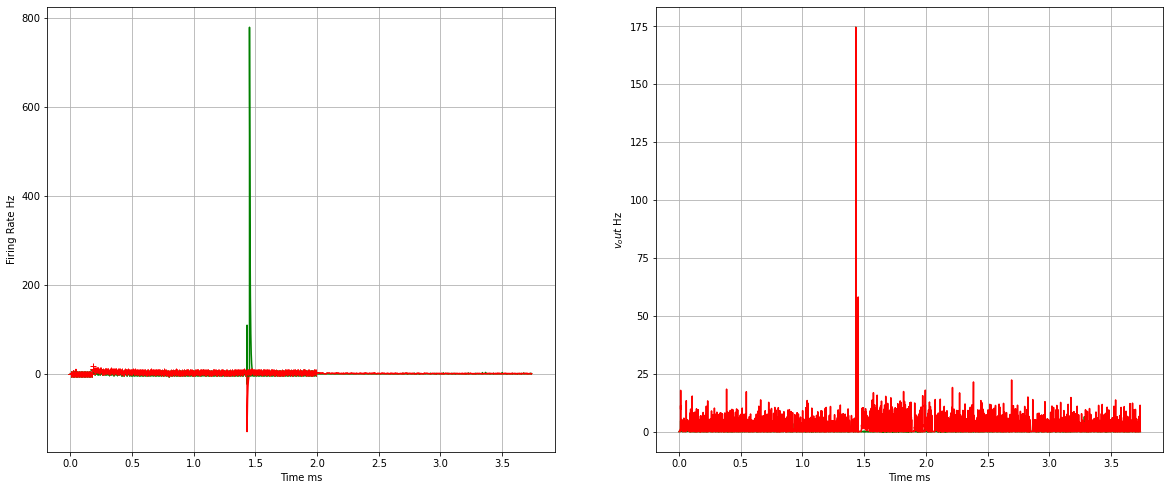

In [63]:
x_transp=np.transpose(x_trace_RS_with_noise)
TF_transp=np.transpose(TF_trace_RS_with_noise)

# RK terms 
ve=x_transp[0]#[1000:] # remove first 10000 elements
vi=x_transp[1]#[999:]
cee=x_transp[2]#[1000:] #cross correlation
cei=x_transp[3]#[1000:]
cie=x_transp[4]#[1000:]
cii=x_transp[5]#[1000:]
w=x_transp[6]

fig2=plt.figure(figsize=(20,18))
ax21=fig2.add_subplot(221)
ax22=fig2.add_subplot(222)

##### Load and plot the network activity of your choice ! #####

#BIN, TimBinned, popRateI,popRateIosc,popRateE,LfrG1,LfrG2,LfrG3=\
#np.load('../../PopRate_of_your_choice.npy',allow_pickle=True)
#ax21.plot(t_trace1,  ve1, color="green", label="excitory firing rate")
#ax21.plot(t_trace1, vi1, color="red", label="inhibitory firing rate")
#ax21.plot(TimBinned/1000,  popRateG1, color="blue", label="excitatory firing rate")
#ax21.plot(TimBinned/1000, popRateG2, color="yellow", label="inhibitory firing rate")
#ax21.plot(TimBinned/1000, popRateIosc, color="purple",ls="--", label="inhibitory firing rate")

ax21.plot(t_trace2,  ve, color="green", label="exc FR mean-field")
ax21.plot(t_trace2, vi, color="red", label="inh FR mean-field")
ax21.plot(TimBinned/1000,  popRateG2, 'g+', label="exc FR AdEx")
ax21.plot(TimBinned/1000, popRateG1, 'r+', label="inh FR AdEx")
#ax21.plot(t_trace, vib, color="orange",ls="--", label="inhibitory firing rate")

#ax21.plot(t_trace, cee, color="blue", label="inhibitory firing rate")
#ax21.plot(t_trace, ciaia, color="purple", label="inhibitory firing rate")
#ax21.plot(t_trace, cibib, color="yellow", label="inhibitory firing rate")

#ax21.set_ylim(0.1,10)
ax21.set_ylabel('Firing Rate Hz')
ax21.set_xlabel('Time ms')
ax21.grid(True)

###### Plot the instantaneous transfer functions #######

ax22.plot(t_trace2,  TF_transp[0], color="green", label="excitory TF")
ax22.plot(t_trace2, TF_transp[1], color="red", label="inhibitory TF")
#ax22.plot(t_trace, TF_transp_BNet_8p7[1], color="red",ls="--", label="inhibitory TF")
#ax22.set_xlim(0.9,1)
#ax22.set_ylim(0,10)
ax22.set_ylabel('$v_out$ Hz')
ax22.set_xlabel('Time ms')
ax22.grid(True)

In [178]:
LwG2[a].limit()

AttributeError: 'numpy.ndarray' object has no attribute 'limit'

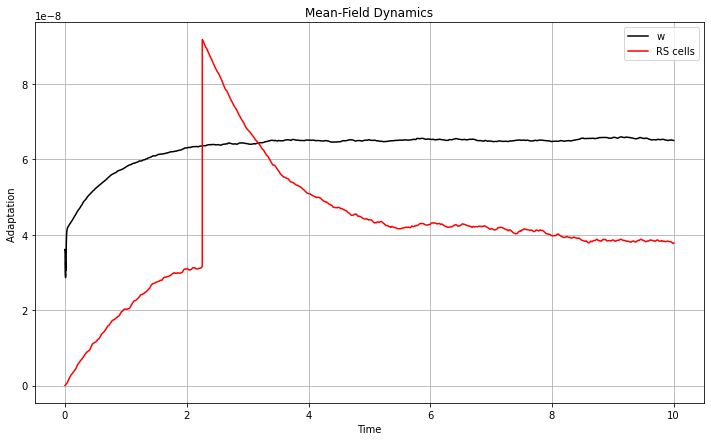

In [191]:
plt.figure(figsize=(12, 7))
#plt.plot(t_trace, ve, color="green", label="excitory firing rate")
#plt.plot(t_trace, vi, color="red", label="inhibitory firing rate")
#plt.plot(t_trace, cee, color="blue", label="excitory cee")
#plt.plot(t_trace, cii, color="purple", label="inhibitory cii")
#plt.plot(t_trace, cei, color="yellow", label="cei")
#plt.plot(t_trace, cie, color="orange", label="cie")
plt.plot(t_trace2,w*1e3,color="black",label="w")
for a in range(Nrecord):
    #plt.plot(Ltime, LVG1[a],'r',label='RS cells') 
    plt.plot(Ltime/1000, (LwG2[a]+LwG1[a]),'r',label='RS cells')
    #plt.plot(Ltime, LVG2[a],'g',label='FS cells')
    #plt.plot(Ltime, LwG2[a],'g',label='FS cells')
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red", ls="--")
#plt.plot(t_trace,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Time")
plt.grid(True)
plt.ylabel("Adaptation ")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(0,5e-8)
#plt.xlim(3,10)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1,) and (100000,)

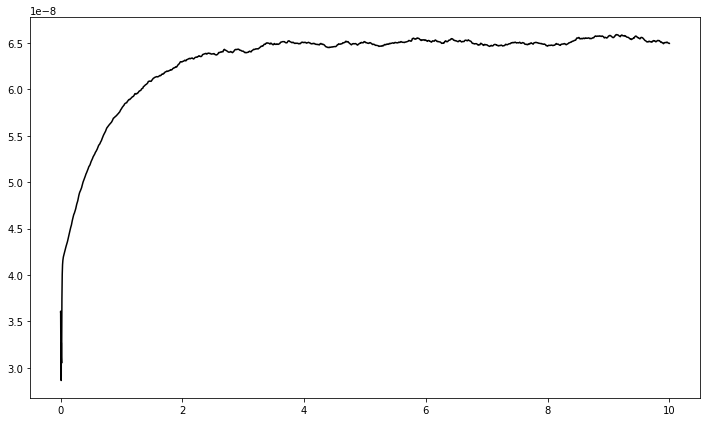

In [194]:
plt.figure(figsize=(12, 7))
#plt.plot(t_trace, ve, color="green", label="excitory firing rate")
#plt.plot(t_trace, vi, color="red", label="inhibitory firing rate")
#plt.plot(t_trace, cee, color="blue", label="excitory cee")
#plt.plot(t_trace, cii, color="purple", label="inhibitory cii")
#plt.plot(t_trace, cei, color="yellow", label="cei")
#plt.plot(t_trace, cie, color="orange", label="cie")
plt.plot(t_trace2,w*1e3,color="black",label="w")
for a in range(Nrecord):
    #plt.plot(Ltime, LVG1[a],'r',label='RS cells') 
    plt.plot(b2, LwG2[a],'r',label='RS cells')
    #plt.plot(Ltime, LVG2[a],'g',label='FS cells')
    #plt.plot(Ltime, LwG2[a],'g',label='FS cells')
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red", ls="--")
#plt.plot(t_trace,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Time")
plt.grid(True)
plt.ylabel("Adaptation ")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(0,5e-8)
#plt.xlim(3,10)
plt.show()

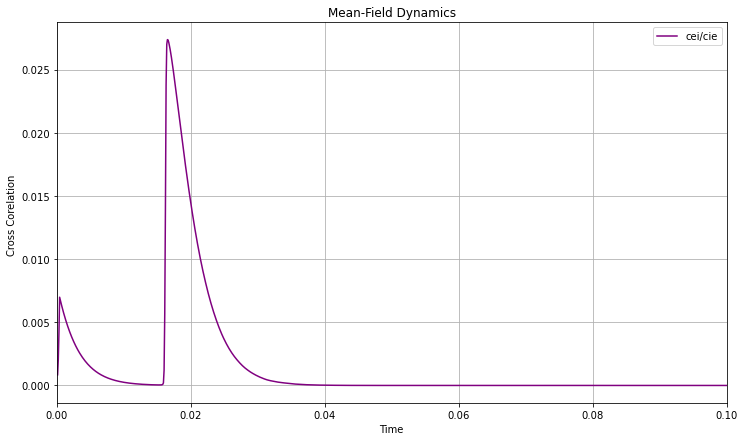

In [199]:
plt.figure(figsize=(12, 7))
#plt.plot(t_trace, ve, color="green", label="excitory firing rate")
#plt.plot(t_trace, vi, color="red", label="inhibitory firing rate")
#plt.plot(t_trace2, cee, color="blue", label="excitory cee")
#plt.plot(t_trace2, cii, color="purple", label="inhibitory cii")
plt.plot(t_trace2, cei*1e-5, color="purple", label="cei/cie")
#plt.plot(t_trace2, cie, color="orange", label="cie")
#plt.plot(t_trace2,w*1e3,color="black",label="w")
#for a in range(Nrecord):
    #plt.plot(Ltime, LVG1[a],'r',label='RS cells') 
    #plt.plot(Ltime/1000, LwG2[a],'r',label='RS cells')
    #plt.plot(Ltime, LVG2[a],'g',label='FS cells')
    #plt.plot(Ltime, LwG2[a],'g',label='FS cells')
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red", ls="--")
#plt.plot(t_trace,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Time")
plt.grid(True)
plt.ylabel("Cross Corelation ")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(-0.01,0.1)
plt.xlim(0,0.1)
plt.show()

# Interconn networks SIM1